# The multislice algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ase.io import read

from abtem.waves import Waves
from abtem.potentials import Potential
from abtem.plot import plot_atoms
from abtem.parametrizations import lobato

## Specimen potential
The electron beam interacts with the specimen through the Coulomb potential of the electrons and nuclei in the specimen. The electron charge distribution of an atom can be calculated from a first-principles electronic structure calculation, while the atomic nuclei are a point charges at the resolution of a TEM. Given a charge distribution, the potential can be obtained via Poisson's equation. 

Simulation codes include a parametrization of the atomic potentials, with a table of parameters for each element fitted to Hartree-Fock calculations. Below we show the radial depedence of the electrostatic potential of five selected elements, using the default parametrization in abTEM. This parametrization is due to Lobato et. al., it is the latest and most accurate parametrization.

In [2]:
from abtem.parametrizations import load_lobato_parameters

parameters = load_lobato_parameters()

parameters[6]

NameError: name 'load_lobato_parameters' is not defined

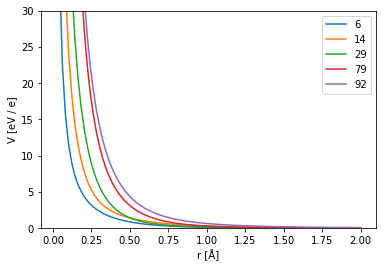

In [13]:
atomic_numbers = [6, 14, 29, 79, 92]

r = np.linspace(0,2,100)

for atomic_number in atomic_numbers:
    v = lobato(r, parameters[atomic_number])
    plt.plot(r, v, label=atomic_number)

plt.xlabel('r [Å]')
plt.ylabel('V [eV / e]')
plt.ylim([0,30])
plt.legend();

The full specimen potential, $V(r)$, is then obtained as a linear superposition of the atomic potentials

$$
    V(r) = \sum_i V_i(r-r_i) \quad ,
$$

where $V_i(r)$ is the atomic potential of the $i$'th atom. This model obviously neglects any effect due to bonding and charge transfer. However, since the nucleus and core electrons constitute most of the charge in an atom, this is often reasonable approximation, which gets progressively better as the atomic number increases. Nonetheless, due to recent improvements in microscopes, interest in going beyond this approximation have started. For example, it has been shown that simulated images based on potentials from DFT calculations can provide a better match with experimental data for light elements. This will be investigated later in this tutorial.

Below the projected potential of one layer of Strontium Titanate is shown.

In [ ]:
srtio = read('SrTiO.traj')
srtio *= (2,2,1)
srtio.center()

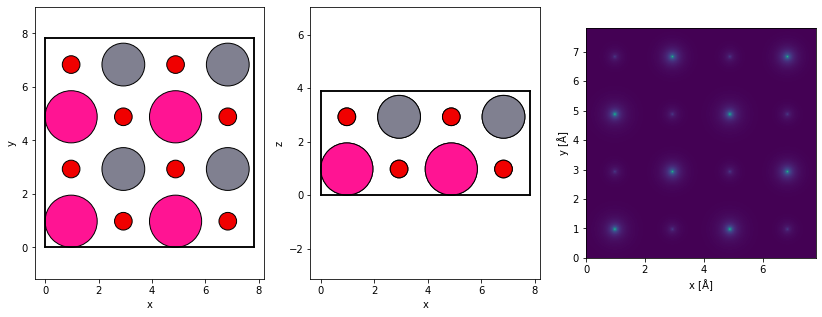

In [17]:

potential = Potential(srtio, num_slices=1, gpts=1024)

proj_potential = potential.get_slice(0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))
plot_atoms(srtio, ax=ax1)
plot_atoms(srtio, ax=ax2, plane='xz')
ax3.imshow(proj_potential.T, extent=[0, potential.extent[0], 0, potential.extent[1]], origin='lower')
ax3.set_xlabel('x [Å]')
ax3.set_ylabel('y [Å]');